Author: Alex Cohen Dambrós Lopes 

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Getting all light curves from space telescopes and running their pre-processing and data analysis
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

This is an example code used to obtain light curves from space telescopes and preprocess 
them automatically


# Imports

In [ ]:
import pandas as pd
import numpy as np
import warnings
import lightkurve as lk
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import shutil
from Functions import all_functions

# General Functions

In [ ]:
def add_value_labels(ax, spacing=5):
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va) 

# Presets

In [ ]:
# ============= RandomState =============
random_state = np.random.RandomState(123)


# ============= Warnings =============
warnings.simplefilter("ignore")


pd.set_option('display.max_columns', None)  # show all cols
pd.set_option('display.max_rows', None) # show all rows
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be

# Download Data

In [ ]:
# all_functions.download_all_datasets()

# Open Datasets

In [ ]:
df_tess = all_functions.read_dataset('tess')
df_kepler = all_functions.read_dataset('kepler')
df_k2 = all_functions.read_dataset('k2')

# Initial Analysis

## Head of Data

In [ ]:
df_tess.head()

In [ ]:
df_kepler.head()

In [ ]:
df_k2.head()

In [ ]:
#  Rename specific columns
df_tess.rename(columns={"tfopwg_disp": "disposition"}, inplace = True)
df_kepler.rename(columns={"koi_disposition": "disposition"}, inplace = True)

## Data Visualization

In [ ]:
telescope_data_list = {"TESS": df_tess, "KEPLER": df_kepler, "K2": df_k2}

In [ ]:
"""
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Total number of instances and columns
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
"""

list_disposition = ['FALSE POSITIVE', 'CONFIRMED']

for telescope, df_telescope in telescope_data_list.items():
    print(f"============ {telescope} ============")
    print(f"For the data collected by the {telescope} space telescope, it has {df_telescope.shape[1]} columns and {df_telescope.shape[0]} instances.")
    
    """
    =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    Percentage of false positives and candidates
    =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    """
    
    df_filtered = df_telescope[(df_telescope['disposition'] == 'FALSE POSITIVE') | (df_telescope['disposition'] == 'CONFIRMED')]
    sum_false_positives = (df_filtered['disposition'] == 'FALSE POSITIVE').sum()
    sum_confirmed = (df_filtered['disposition'] == 'CONFIRMED').sum()
    print("Total False Positives: %d, Total Confirmed: %d, Others: %d" % (sum_false_positives, sum_confirmed, df_telescope.shape[0] - (sum_confirmed + sum_false_positives)))
    print("Percentage False Positives: %.2f%%, Percentage Confirmed: %.2f%%, Percentage of Others: %.2f%%" % ((sum_false_positives / df_telescope.shape[0]) * 100, (sum_confirmed / df_telescope.shape[0]) * 100, (df_telescope.shape[0] - (sum_confirmed + sum_false_positives)) * 100 / df_telescope.shape[0]))
    

In [ ]:
# TESS
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x= df_tess["disposition"], color = "#0092D4", ax=ax)
add_value_labels(ax)
plt.title("Amount of disposition of the data present in the TESS telescope", loc="left")
plt.xlabel("Disposition")
plt.ylabel("Amount")
plt.ylim(0, 5000)
plt.show()

In [ ]:
# KEPLER
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x= df_kepler["disposition"], color = "#0092D4", ax=ax)
add_value_labels(ax)
plt.title("Amount of disposition of the data present in the KEPLER telescope", loc="left")
plt.xlabel("Disposition")
plt.ylabel("Amount")
plt.ylim(0, 5200)
plt.show()

In [ ]:
# K2
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x= df_k2["disposition"], color = "#0092D4", ax=ax)
add_value_labels(ax)
plt.title("Amount of disposition of the data present in the K2 telescope", loc="left")
plt.xlabel("Disposition")
plt.ylabel("Amount")
plt.ylim(0, 2500)
plt.show()

# Percentage of null values ​​in each column of the TESS telescope

In [ ]:
null_values = round((df_tess.isna().sum() / len(df_tess)) * 100, 2)
null_values = null_values.to_frame()
null_values.rename(columns={0: "%null"}, inplace = True)
null_values

# Percentage of null values ​​in each column of the KEPLER telescope

In [ ]:
null_values = round((df_kepler.isna().sum() / len(df_kepler)) * 100, 2)
null_values = null_values.to_frame()
null_values.rename(columns={0: "%null"}, inplace = True)
null_values

# Percentage of null values ​​in each column of the K2 telescope

In [ ]:
null_values = round((df_k2.isna().sum() / len(df_k2)) * 100, 2)
null_values = null_values.to_frame()
null_values.rename(columns={0: "%null"}, inplace = True)
null_values

# Selecting specific columns for the first test

In [ ]:
# drop rows of planets that were discovered by methods other than transit
df_k2 = df_k2[df_k2['discoverymethod'] != 'Radial Velocity']

In [ ]:
# TESS
df_tess  = df_tess[['tid', 'disposition', 'pl_orbper', 'pl_trandurh']]
df_tess.rename(columns={"tid": "id_target", "pl_orbper": "period", "pl_trandurh": "duration"}, inplace = True)

# KEPLER
df_kepler = df_kepler[['kepid', 'disposition','koi_period','koi_duration', 'koi_time0bk']]
df_kepler.rename(columns={"kepid": "id_target", "koi_period": "period", "koi_duration": "duration"}, inplace = True)

# K2
df_k2 = df_k2[['tic_id', 'disposition', 'pl_orbper', 'pl_trandur']]
df_k2.rename(columns={"tic_id": "id_target", "pl_orbper": "period", "pl_trandur": "duration"}, inplace = True)

# Local View & Global View

- global view -> All light curves are binned to the same length

- local view -> so that the transit occupies a fixed fraction of the resulting vector.

The global view has a fixed length of 2001 bins, while the local view has a fixed length of 201 bins.

In [ ]:
candidate_disposition = ['CONFIRMED', 'FALSE POSITIVE']


# filtering the data by confirmed targets and false positives
df_tess = df_tess[df_tess['disposition'].isin(candidate_disposition)]
df_kepler = df_kepler[df_kepler['disposition'].isin(candidate_disposition)]
df_k2 = df_k2[df_k2['disposition'].isin(candidate_disposition)]


In [ ]:
# telescopes_list = {'Kepler': df_kepler.sample(1), 'TESS': df_tess.sample(1)}
telescopes_list = {'Kepler': df_kepler.head(1)}


local_curves = []
local_targets = []

global_curves = []
global_targets = []

Telescope: Kepler
KIC 10797460 target pre-processing performed, Disposition:CONFIRMED


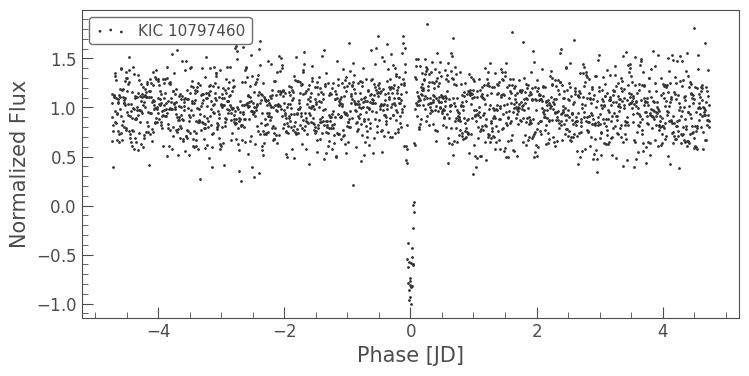

In [37]:
for name_telescope, df_telescope in telescopes_list.items():
    print("Telescope:", name_telescope)
    for index, row in df_telescope.iterrows():
        try:
            id_target, period, duration, t0 = row[0], row[2], row[3], row[4]
        except:
            id_target, period, duration = row[0], row[2], row[3]
            
        try:
            
            if name_telescope == 'Kepler':
                id_target = 'KIC ' + str(id_target)
                lcs = lk.search_lightcurve(id_target, author= name_telescope, cadence='long').download_all()
                
            elif name_telescope == 'TESS':
                id_target = 'TIC ' + str(id_target)
                lcs = lk.search_lightcurve(id_target, mission= name_telescope, cadence='long').download_all()
            
            if not(lcs is None):
                
                # This method concatenates all quarters in our LightCurveCollection together, and normalizes them at the same time.
                lc_raw = lcs.stitch()
                
                # Clean outliers, but only those that are above the mean level (e.g. attributable to stellar flares or cosmic rays).
                lc_clean = lc_raw.remove_outliers(sigma=3)
                
                # We have to mask the transit to avoid self-subtraction the genuine planet signal when we flatten the lightcurve. We have to do a hack to find where the time series should be masked.
                if t0 != None:
                    temp_fold = lc_clean.fold(period, epoch_time=t0)
                else:
                    temp_fold = lc_clean.fold(period)
            
                fractional_duration = (duration / 24.0) / period
                phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5)
                transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])

                lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask)
                
                # Now fold the cleaned, flattened lightcurve:
                if t0 != None:
                    lc_fold = lc_flat.fold(period, epoch_time=t0)
                else:
                    lc_fold = lc_flat.fold(period)
                    
                # ========= Defining global curves =========
                lc_global = lc_fold.bin(bins=2001).normalize() - 1
                lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1

                phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration)
                lc_zoom = lc_fold[phase_mask]


                # ========= Defining local curves =========
                lc_local = lc_zoom.bin(bins=201).normalize() - 1
                lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1
        
                local_targets.append(row[1])
                local_curves.append(lc_local.flux.value)
                
                global_targets.append(row[1])
                global_curves.append(lc_global.flux.value)
            
                lc_global.scatter()
                
                print(f"{id_target} target pre-processing performed, Disposition:{row[1]}")
            
            else:
                print("Error downloading target data:", id_target)
        
        except Exception as error:
            print(f"Failed at id: {id_target} | Error: {error}")
            
            
df_local = pd.DataFrame(local_curves)
df_global = pd.DataFrame(global_curves)

df_global = df_global.interpolate(axis=1)
df_local = df_local.interpolate(axis=1)

df_global['label'] = pd.Series(global_targets)
df_local['label'] = pd.Series(local_targets)

get_current_path = os.getcwd()

# Path
path = os.path.join(get_current_path, 'Preprocessed')

# ============= Create the directory =============
try:
    if os.path.exists(path):
        shutil.rmtree(path, ignore_errors=True)
        os.makedirs(path, exist_ok = True)
    else:
        os.makedirs(path, exist_ok = True)
    
except OSError as error:
    print("Directory can not be created: ", error)
    
df_global.to_csv(path+ '\\preprocessed_local_view.csv')  
df_local.to_csv(path+ '\\preprocessed_global_view.csv')

In [ ]:
"""
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Important !!!
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

The 'bin' function present in the current version of the lightkurve 2.3.0 library has an object type error for this reason 
it is necessary to replace the function in the open source library for the code to work correctly! 

This function below is the function present in previous versions of the library. 
It is not possible to go back to old versions of the package in general because there are functions that were not implemented before.


def bin(
        self,
        time_bin_size=None,
        time_bin_start=None,
        n_bins=None,
        aggregate_func=None,
        bins=None,
        binsize=None,
    ):
    
        if binsize is not None and bins is not None:
            raise ValueError("Only one of ``bins`` and ``binsize`` can be specified.")
        elif (binsize is not None or bins is not None) and (
            time_bin_size is not None or n_bins is not None
        ):
            raise ValueError(
                "``bins`` or ``binsize`` conflicts with "
                "``n_bins`` or ``time_bin_size``."
            )
        elif bins is not None:
            if np.array(bins).dtype != np.int:
                raise TypeError("``bins`` must have integer type.")
            elif np.size(bins) != 1:
                raise ValueError("``bins`` must be a single number.")

        if time_bin_start is None:
            time_bin_start = self.time[0]
        if not isinstance(time_bin_start, (Time, TimeDelta)):
            if isinstance(self.time, TimeDelta):
                time_bin_start = TimeDelta(
                    time_bin_start, format=self.time.format, scale=self.time.scale
                )
            else:
                time_bin_start = Time(
                    time_bin_start, format=self.time.format, scale=self.time.scale
                )

        # Backwards compatibility with Lightkurve v1.x
        if time_bin_size is None:
            if bins is not None:
                i = len(self.time) - np.searchsorted(
                    self.time.value, time_bin_start.value - 1e-10
                )
                time_bin_size = (
                    (self.time[-1] - time_bin_start) * i / ((i - 1) * bins)
                ).to(u.day)
            elif binsize is not None:
                i = np.searchsorted(self.time.value, time_bin_start.value - 1e-10)
                time_bin_size = (self.time[i + binsize] - self.time[i]).to(u.day)
            else:
                time_bin_size = 0.5 * u.day
        if not isinstance(time_bin_size, Quantity):
            time_bin_size *= u.day

        # Call AstroPy's aggregate_downsample
        with warnings.catch_warnings():
            # ignore uninteresting empty slice warnings
            warnings.simplefilter("ignore", (RuntimeWarning, AstropyUserWarning))
            ts = aggregate_downsample(
                self,
                time_bin_size=time_bin_size,
                n_bins=n_bins,
                time_bin_start=time_bin_start,
                aggregate_func=aggregate_func,
            )

            # If `flux_err` is populated, assume the errors combine as the root-mean-square
            if np.any(np.isfinite(self.flux_err)):
                rmse_func = (
                    lambda x: np.sqrt(np.nansum(x ** 2)) / len(np.atleast_1d(x))
                    if np.any(np.isfinite(x))
                    else np.nan
                )
                ts_err = aggregate_downsample(
                    self,
                    time_bin_size=time_bin_size,
                    n_bins=n_bins,
                    time_bin_start=time_bin_start,
                    aggregate_func=rmse_func,
                )
                ts["flux_err"] = ts_err["flux_err"]
            # If `flux_err` is unavailable, populate `flux_err` as nanstd(flux)
            else:
                ts_err = aggregate_downsample(
                    self,
                    time_bin_size=time_bin_size,
                    n_bins=n_bins,
                    time_bin_start=time_bin_start,
                    aggregate_func=np.nanstd,
                )
                ts["flux_err"] = ts_err["flux"]

        # Prepare a LightCurve object by ensuring there is a time column
        ts._required_columns = []
        ts.add_column(ts.time_bin_start + ts.time_bin_size / 2.0, name="time")

        # Ensure the required columns appear in the correct order
        for idx, colname in enumerate(self.__class__._required_columns):
            tmpcol = ts[colname]
            ts.remove_column(colname)
            ts.add_column(tmpcol, name=colname, index=idx)

        return self.__class__(ts, meta=self.meta) 
"""